In [26]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
%autoreload 2
import hydra
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchdiffeq
from tqdm.auto import tqdm
from UniversalUnconsciousness.network_modelling.EI_RNN import EI_RNN, compute_lyaps_from_sol
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [228]:
# load the config
with hydra.initialize(version_base="1.3", config_path="../UniversalUnconsciousness/network_modelling/conf"):
    cfg = hydra.compose(config_name="config")

# Build Diluted E-I Balanced Network

The recurrent connections $J^{ij}_{kl}$ denote the synaptic efficacy between the presynaptic $j$ th neuron of the $l$ th population to the post synaptic $i$ th neuron of the $k$ th population, where $k, l = 1, ..., P$, and $i, j = 1, ..., N$.

The connectivity is randomly  diluted so that each connection $J^{ij}_{kl}$ is nonzero with probability $p$, where
$p = \frac{K}{N}$ and zero otherwise.

Past work on random highly connected systems has shown that under fairly general conditions, in the limit of large $K$, the system’s behavior depends only on the first two moments of the connectivity matrix. Hence, the connectivity matrix $J^{ij}_{kl}$ can be replaced by a random matrix of Gaussian-distributed connections where the mean and variance are matched to that of the dilute network. We thus consider a general dynamics of a multiple population network with a fully connected connectivity matrix with Gaussian-distributed connections, $J^{ij}_{kl} = \left(\frac{\bar{g}_{kl}}{N}\right) + \mathcal{J}^{ij}_{kl}$,

$$\frac{d}{dt} h^{i}_k(t) = -h^i_k(t) + \sum_{l=1}^{P} \sum_{j=1}^{N} J^{ij}_{kl} \phi(h^j_l(t)) + \sum_{l=1}^{P} \bar{g}_{kl} m_l(t) + h^0_k$$

where

$$m_k(t) = \frac{1}{N} \sum_{i=1}^{N} \phi(h^i_k(t))$$

are the mean population activities.

The coefficents $\mathcal{J}^{ij}_{kl}$ are drawn from a Gaussian distribution with zero mean and variance $\frac{\bar{g}^2_{kl}}{N}$.

In the dilute network, the mean connection between two populations equals $p\frac{J_{kl}}{\sqrt{K}} = \sqrt{K}\frac{J_{kl}}{N}$. The variances of these connections are $p(1-p)J^2_{kl} = K = (1-K/N)J^2_{kl} = N$. Hence, the corresponding parameters of the equivalent Gaussian network are

$$g^2_{kl} = (1-K/N)J^2_{kl}$$

$$ \bar{g}_{kl} = \sqrt{Kp} J_{kl} = \sqrt{Kp} J_{kl} = N$$

$$h^0_k = \sqrt{Kp} \omega_{km_0}$$



Note that in the dilute networks, $g_{kl}$ and $\bar{g}_{kl}$ are related through

$$ \bar{g}_{kl} = g_{kl} \sqrt{\frac{K}{1-K/N}}$$



In [229]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [245]:
torch.manual_seed(cfg.params.random_state + 6)
cfg.params.EI_RNN_params.g = 1.3
cfg.params.EI_RNN_params.ketamine_scale = 0.95
cfg.params.EI_RNN_params.ketamine_dose = 'low'
model = hydra.utils.instantiate(cfg.params.EI_RNN_params)
model.to(device)

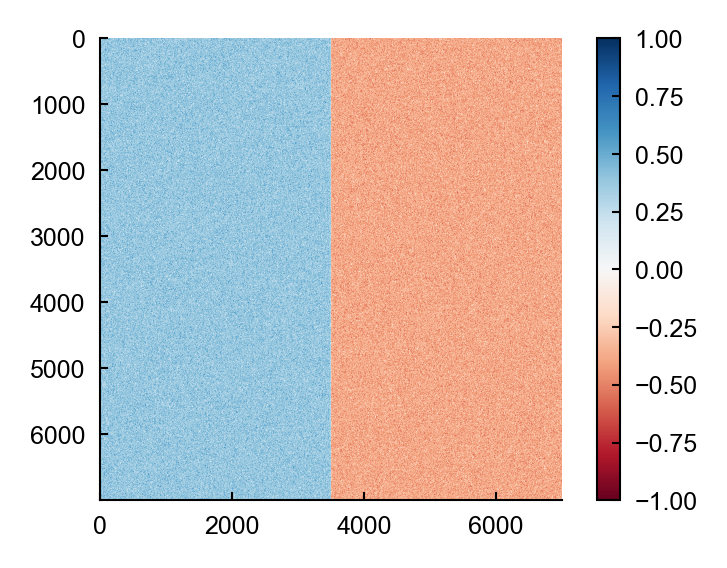

In [246]:
h_0 = torch.randn(2*cfg.params.EI_RNN_params.N, device=device)
time_vals = torch.linspace(0, cfg.params.T, int(cfg.params.T / cfg.params.dt))

# make a new J that is 1 if the value is positive, -1 otherwise
J_binary = torch.where(model.J > 0, torch.tensor(1.0), torch.tensor(-1.0)).to(device)
plt.imshow(J_binary.cpu().numpy(), cmap='RdBu')  # RdBu colormap: red for negative, blue for positive
plt.colorbar()
plt.show()


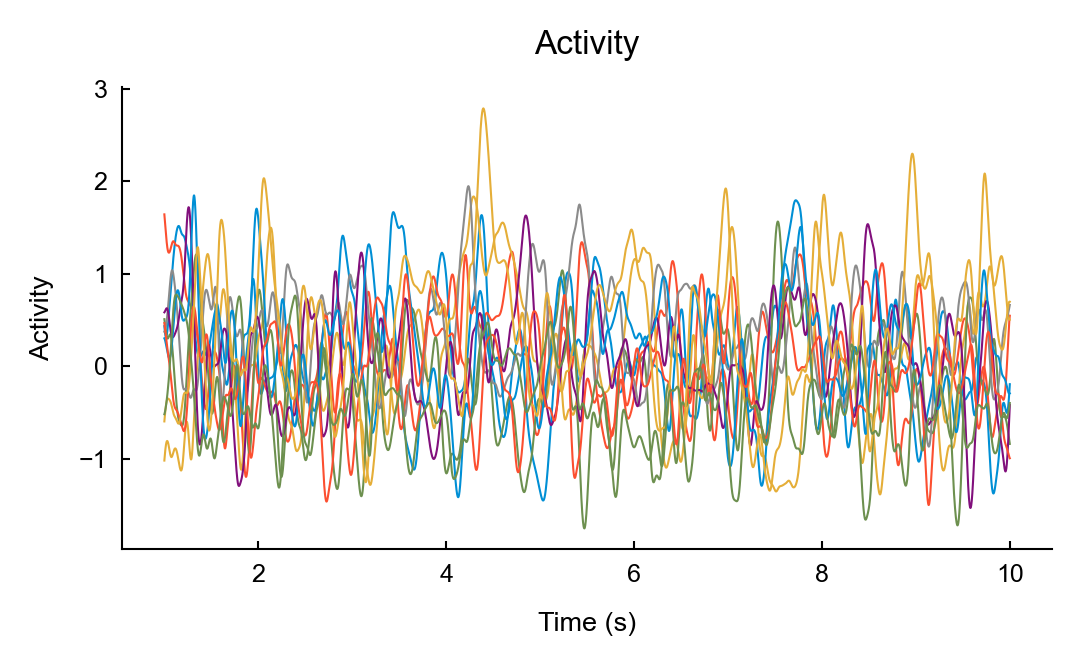

In [247]:
# simulate with torchdiffeq
# verbose=True
sol = torchdiffeq.odeint(model.forward, h_0, time_vals.to(device), method='rk4')

transient_idx = int(cfg.params.transient_pct * len(time_vals))

fig, axs = plt.subplots(1, 1, figsize=(4, 2))
for i in range(10):
    axs.plot(time_vals[transient_idx:].cpu().numpy(), sol.cpu().numpy()[transient_idx:, i])
    
axs.set_xlabel('Time (s)')
axs.set_ylabel('Activity')
axs.set_title('Activity')
plt.show()


In [248]:
lyaps = compute_lyaps_from_sol(sol[transient_idx:transient_idx+1000], model.jac, dt=cfg.params.dt, k=3, verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

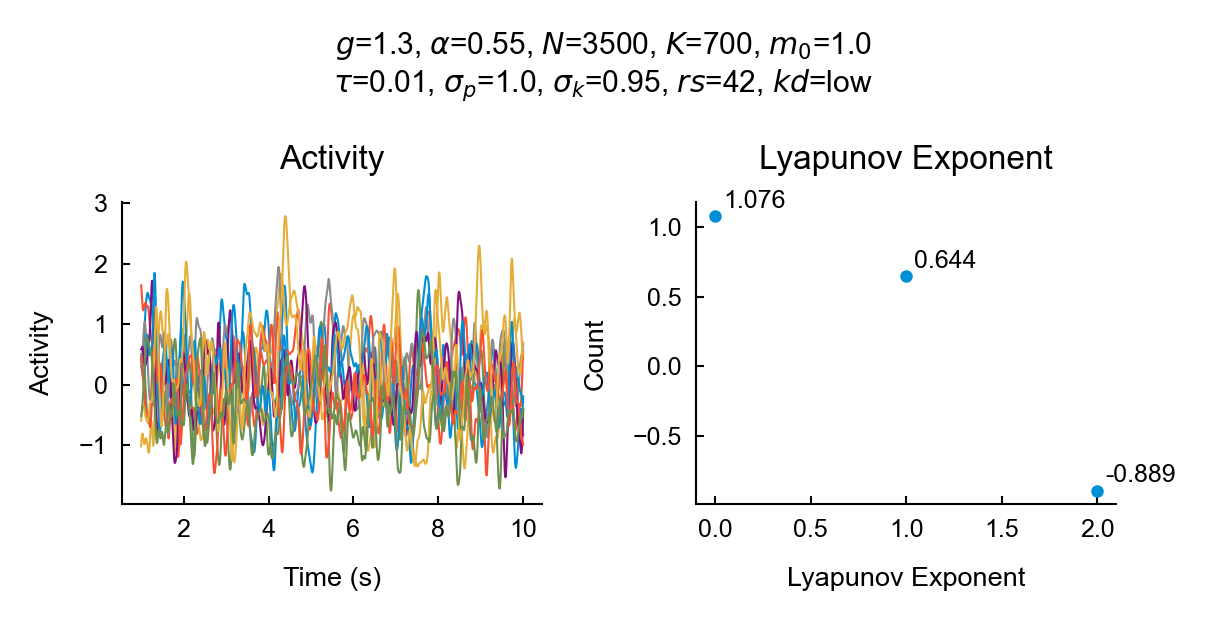

In [249]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
for i in range(10):
    axs[0].plot(time_vals[transient_idx:].cpu().numpy(), sol.cpu().numpy()[transient_idx:, i])
    
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Activity')
axs[0].set_title('Activity')

# plot lyaps
lyap_vals = lyaps.cpu().numpy()[:3]
axs[1].plot(lyap_vals, 'o')
for i, lyap in enumerate(lyap_vals):
    axs[1].annotate(f'{lyap:.3f}', (i, lyap), xytext=(2, 2), textcoords='offset points')
axs[1].set_xlabel('Lyapunov Exponent')
axs[1].set_ylabel('Count')
axs[1].set_title('Lyapunov Exponent')

# put all parameters in the title
plt.suptitle(fr"$g$={model.g}, $\alpha$={model.alpha}, $N$={model.N}, $K$={model.K}, $m_0$={model.m_0}" + '\n' + fr"$\tau$={model.tau}, $\sigma_p$={model.propofol_scale}, $\sigma_k$={model.ketamine_scale}, $rs$={cfg.params.random_state}, $kd$={model.ketamine_dose}")
plt.tight_layout()
plt.show()

# Collect Results from Ketamine Sim

In [35]:
save_dir = '/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/network_modelling/ketamine_sims'

In [36]:
param_folder = f"N_{cfg.params.EI_RNN_params.N}__K_{cfg.params.EI_RNN_params.K}__alpha_{cfg.params.EI_RNN_params.alpha}__m0_{cfg.params.EI_RNN_params.m_0}__tau_{cfg.params.EI_RNN_params.tau}"

In [43]:
simulation_lyaps = {}
g_vals = set()
ketamine_scales = set()
ketamine_doses = set()
random_states = set()
for filename in tqdm(os.listdir(os.path.join(save_dir, param_folder))):
    random_state = int(filename.split('RS')[1].split('_')[1])
    g = float(filename.split('g')[1].split('_')[1])
    ketamine_scale = float(filename.split('ks')[1].split('_')[1])
    ketamine_dose = filename.split('kd')[1].split('.pkl')[0][1:]
    g_vals.add(g)
    ketamine_scales.add(ketamine_scale)
    ketamine_doses.add(ketamine_dose)
    random_states.add(random_state)

    ret = pd.read_pickle(os.path.join(save_dir, param_folder, filename))
    simulation_lyaps[(g, ketamine_scale, ketamine_dose, random_state)] = ret['lyaps']

  0%|          | 0/3081 [00:00<?, ?it/s]

In [44]:
ketamine_dose = 'high'

In [47]:
# sort the random_states
random_states = sorted(list(random_states))

In [60]:
simulation_lyaps_organized = {}
for ketamine_dose in ketamine_doses:
    simulation_lyaps_organized[ketamine_dose] = {}
    for g in g_vals:
        simulation_lyaps_organized[ketamine_dose][g] = {}
        for ketamine_scale in ketamine_scales:
            simulation_lyaps_organized[ketamine_dose][g][ketamine_scale] = None
            for random_state in random_states:
                if (g, ketamine_scale, ketamine_dose, random_state) in simulation_lyaps:
                    if simulation_lyaps_organized[ketamine_dose][g][ketamine_scale] is None:
                        simulation_lyaps_organized[ketamine_dose][g][ketamine_scale] = simulation_lyaps[(g, ketamine_scale, ketamine_dose, random_state)].unsqueeze(0)
                    else:
                        simulation_lyaps_organized[ketamine_dose][g][ketamine_scale] = torch.cat((simulation_lyaps_organized[ketamine_dose][g][ketamine_scale], simulation_lyaps[(g, ketamine_scale, ketamine_dose, random_state)].unsqueeze(0)), dim=0)
                else:
                    print(f"No lyaps found for {g}, {ketamine_scale}, {ketamine_dose}, {random_state}")


In [135]:
ketamine_dose = 'high'
g = 1.5

In [136]:
g_lyap_means = []
g_lyap_sems = []
plot_ketamine_scales = []
ketamine_scales = np.array(sorted(list(ketamine_scales)))
for ketamine_scale in ketamine_scales:
    if ketamine_scale <= 1:
        plot_ketamine_scales.append(np.log10(np.abs((ketamine_scale - 1)/1)) if ketamine_scale != 1 else 0)
        g_lyap_means.append(simulation_lyaps_organized[ketamine_dose][g][ketamine_scale].mean(dim=0)[0])
        g_lyap_sems.append(simulation_lyaps_organized[ketamine_dose][g][ketamine_scale].std(dim=0)[0] / sqrt(len(simulation_lyaps_organized[ketamine_dose][g][ketamine_scale])))

In [185]:
simulation_lyaps_organized[kd][g][1][:, 0]

tensor([1.2688, 2.9383, 0.7995, 3.3583, 2.9500, 3.0310, 3.4379, 2.7889, 2.3095,
        2.6311])

In [186]:
simulation_lyaps_organized[kd][g][ks][:, 0]

tensor([1.1118, 2.4950, 1.1224, 2.9548, 3.5698, 3.6481, 3.3017, 1.8040, 3.2142,
        2.3124])

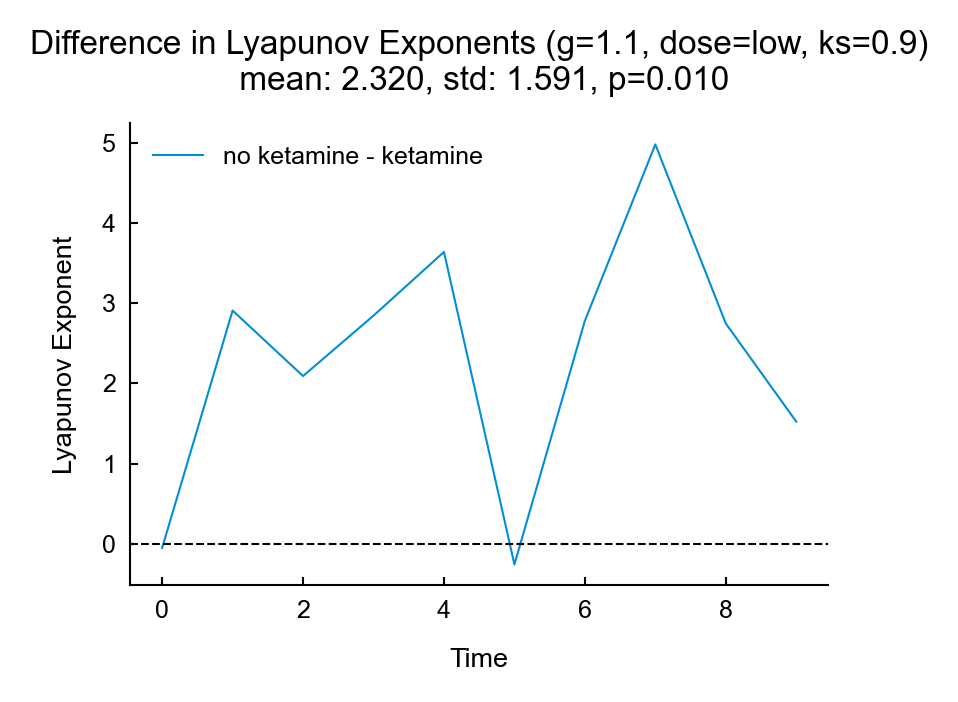

In [227]:
g = 1.1
kd = 'low'
ks = 0.9

no_ket = simulation_lyaps_organized[kd][g][1][:, 0]
ket = simulation_lyaps_organized[kd][g][ks][:, 0]
diffs = no_ket - ket
plt.plot(diffs, label='no ketamine - ketamine')
plt.axhline(0, color='k', linestyle='--')
p = wilcoxon(no_ket, ket, alternative='two-sided').pvalue
# if kd == 'high':
#     p = wilcoxon(no_ket, ket, alternative='greater').pvalue
# else:
#     p = wilcoxon(no_ket, ket, alternative='less').pvalue
plt.title(f'Difference in Lyapunov Exponents (g={g}, dose={kd}, ks={ks})\n mean: {diffs.mean():.3f}, std: {diffs.std():.3f}, p={p:.3f}')
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.legend()
plt.show()

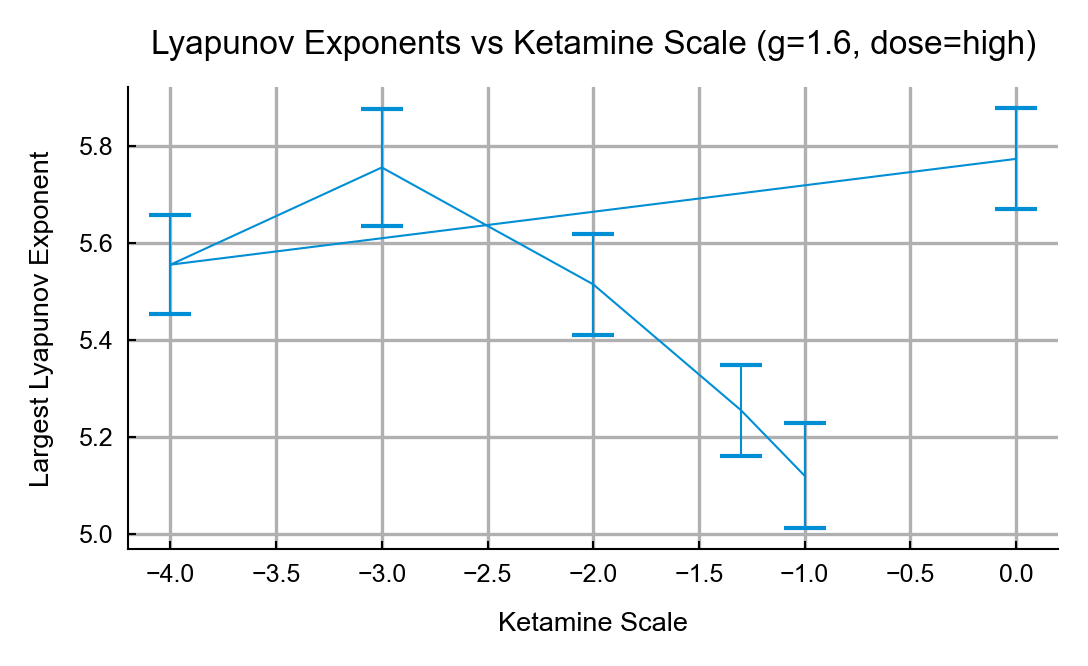

In [114]:
plt.figure(figsize=(4, 2))
plt.errorbar(plot_ketamine_scales, g_lyap_means, yerr=g_lyap_sems, capsize=5)
plt.xlabel('Ketamine Scale')
plt.ylabel('Largest Lyapunov Exponent')
plt.title(f'Lyapunov Exponents vs Ketamine Scale (g={g}, dose={ketamine_dose})')
plt.grid(True)
plt.show()
